# Named Entity Recognition

Задание — написать решение по извлечению сущностей из документов (новостных текстов).

In [2]:
!pip install gigachat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.5 MB/s eta 0:00:00


In [3]:
!pip3 install spacy -q
!python3 -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 103.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import os
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import pytest
import seaborn as sns
import spacy
from gigachat import GigaChat
from tqdm import tqdm

nlp = spacy.load("ru_core_news_sm")
DOCUMENT_ID_PATTERN = re.compile("_(\d*).out")
ENTITY_TYPES = ["PER", "ORG", "LOC", "EVT", "PRO"]
sns.set_style("darkgrid")
os.environ["GIGACHAT_API_KEY"] = ...

## Задание 1
Опишите задачу с точки зрения NLP. Что это за задача, какие классические методы существуют для ее решения? Как ее можно решать через LLM? Как обычно оценивают качество моделей в этой задаче?

Это задача Named Entity Recognition, т.е. буквально извелечение именнованных сущностей (по типу имён, названий и тд) из текста.

Методы её решения делятся на несколько типов:

1. **rule-based**: используют шаблоны, основанные на структуре и контексте, для поиска слов. Обычно это регулярные выражения (для поиска email, например) или контекстные маркеры вместе с паттернами частями речи (например, если контекст "компания А" и А -- это существительное, то А -- это скорее всего название этой компании).

Плюсы и минусы очевидны: с одной стороны, эффективно, не требует никакого обучения; с другой, нужно вручную подбирать эти шаблоны, которые могут сломаться при изменении текста, а также нет гарантий на точность этих паттернов.

2. **dictionary-based**: создаётся большой словарь слов, которые нужно найти, и они ищутся буквально посимвольным сравнением.

Плюсы: эффективно и обладает высокой точностью.
Минусы: требует изменений словаря при изменении задачи, не распознаёт новые слова, а также есть проблема с падежами и омонимами.

3. с помощью специально дообученных на NER **BERT-like архитектур**.

4. также я знаю, что на данный момент SOTA решение в этой задаче -- это модель **GLiNER**, которая формулирует задачу NER как генеративную и использует gpt в качестве основы.

5. с помощью промптинга **LLM**, как в этом задании, через zero-shot или few-shot (т.е. без примеров того, как нужно выполнить задачу, и с ними)

Метрики качества по сути стандартные из машинного обучения, т.е.
* precision -- доля правильно предсказанных сущностей из всех предсказанных,
* recall -- доля правильно предсказанных сущностей из всех истинных,
* f1-score -- гармоническое среднее precision и recall

## Задание 2
Реализуйте чтение датасета в pandas DataFrame с обязательными колонками "document_id", "document_text", "entity", "gold_answer". Выведите шапку датафрейма.

In [5]:
!wget https://bsnlp.cs.helsinki.fi/bsnlp-2019/sample_pl_cs_ru_bg.zip -O news.zip
!unzip news.zip -d news
!mkdir ru_news_raw
!mv news/sample_pl_cs_ru_bg/raw/ru/* ru_news_raw/
!mkdir ru_news_annotated
!mv news/sample_pl_cs_ru_bg/annotated/ru/* ru_news_annotated/

--2025-05-31 09:00:21--  https://bsnlp.cs.helsinki.fi/bsnlp-2019/sample_pl_cs_ru_bg.zip
Resolving bsnlp.cs.helsinki.fi (bsnlp.cs.helsinki.fi)... 128.214.166.78
Connecting to bsnlp.cs.helsinki.fi (bsnlp.cs.helsinki.fi)|128.214.166.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136627 (133K) [application/zip]
Saving to: ‘news.zip’

news.zip            100%[===================>] 133.42K   416KB/s    in 0.3s    

2025-05-31 09:00:23 (416 KB/s) - ‘news.zip’ saved [136627/136627]

Archive:  news.zip
   creating: news/sample_pl_cs_ru_bg/
   creating: news/sample_pl_cs_ru_bg/annotated/
   creating: news/sample_pl_cs_ru_bg/annotated/bg/
  inflating: news/sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_1.out  
  inflating: news/sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_11.out  
  inflating: news/sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_13.out  
  inflating: news/sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_14.out  
  inflating: news/sampl

In [6]:
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])


def read_dataset():
    dataset_dict = defaultdict(list)
    for doc in os.listdir("ru_news_annotated"):
        df_annt = pd.read_csv(
            "ru_news_annotated/" + doc,
            sep="\t",
            header=0,
            names=["Entity", "Canonical_Form", "Entity_Type", "NER_ID"],
        )
        df_annt["Entity"] = df_annt["Entity"].apply(lemmatize)
        df_annt.drop_duplicates("Entity", inplace=True)
        dataset_dict["document_id"].extend(
            [re.findall(DOCUMENT_ID_PATTERN, doc)[0]] * len(df_annt["Entity"])
        )
        dataset_dict["gold_answer"].extend(df_annt["Entity"].tolist())
        dataset_dict["entity"].extend(df_annt["Entity_Type"].tolist())
        df_text = ""
        with open("ru_news_raw/" + doc[:-3] + "txt", "r", encoding="utf-8") as f:
            for _ in range(4):
                next(f)
            for line in f:
                df_text += line.strip() + " "
        dataset_dict["document_text"].extend([df_text] * len(df_annt["Entity"]))
    return pd.DataFrame.from_dict(dataset_dict)


df = read_dataset()
df.head(20)

,document_id,gold_answer,entity,document_text
0,10,brexit,EVT,Тереза Мэй рассчитывает усидеть в седле до зав...
1,10,альбиона,LOC,Тереза Мэй рассчитывает усидеть в седле до зав...
2,10,альбионе,LOC,Тереза Мэй рассчитывает усидеть в седле до зав...
3,10,борис джонсон,PER,Тереза Мэй рассчитывает усидеть в седле до зав...
4,10,британия,LOC,Тереза Мэй рассчитывает усидеть в седле до зав...
5,10,брюсселе,LOC,Тереза Мэй рассчитывает усидеть в седле до зав...
6,10,брюссель,LOC,Тереза Мэй рассчитывает усидеть в седле до зав...
7,10,джонсон,PER,Тереза Мэй рассчитывает усидеть в седле до зав...
8,10,ес,ORG,Тереза Мэй рассчитывает усидеть в седле до зав...
9,10,еврокомиссия,ORG,Тереза Мэй рассчитывает усидеть в седле до зав...


## Задание 3
Напишите функцию, которая принимает на вход строку датафрейма и выдает текст входного сообщения для LLM.

In [7]:
def get_prompt(df_row):
    text = df_row["document_text"]
    prompt = f"""
    Выдели основные сущности с типами {', '.join(ENTITY_TYPES)} из следующего текста как в примере.
    Не меняй их форму (падеж, число и тд), не пиши никаких дополнительных комментариев, а также укажи сами типы. Не используй нумерованные списки: все сущности выведи с новой строки через дефис.
    Пример:
    <текст>
    Борис Джонсон ушел в отставку с поста главы МИД Великобритании
    <сущности>
    **PER**
    - Борис Джонсон
    **ORG**
    - МИД Великобритании
    <текст>\n{text}"""
    return prompt


for _, row in df.drop_duplicates("document_id").iterrows():
    print(f"prompt for document {row['document_id']}: {get_prompt(row)}\n")

prompt for document 10: 
    Выдели основные сущности с типами PER, ORG, LOC, EVT, PRO из следующего текста как в примере.
    Не меняй их форму (падеж, число и тд), не пиши никаких дополнительных комментариев, а также укажи сами типы. Не используй нумерованные списки: все сущности выведи с новой строки через дефис.
    Пример:
    <текст>
    Борис Джонсон ушел в отставку с поста главы МИД Великобритании
    <сущности>
    **PER**
    - Борис Джонсон
    **ORG**
    - МИД Великобритании
    <текст>
Тереза Мэй рассчитывает усидеть в седле до завершения процедуры Brexit  Тем не менее, по сведениям британских СМИ, на предстоящей в конце сентября конференции партии тори противники Мэй навяжут ей серьезный бой, из которого не факт, что она выйдет победителем. Фаворит букмекеров в качестве возможного сменщика нынешнего премьера, бывший министр иностранных дел Британии Борис Джонсон намерен выступить с альтернативным докладом, который не оставит камня на камне от взглядов главы правительства

## Задание 4
Получите ответы GigaChat для всех документов. Документов всего 9, поэтому сделать это можно вручную, пользуясь веб-интерфейсом GigaChat или ботом в ВК или Телеграме. Не очищайте историю сообщений, чтобы потом продемонстрировать подлинность ответов на онлайн-собеседовании.

In [10]:
# скачиваем сертификат Минцифры для взаимодействия с GigaChat
!curl -k "https://gu-st.ru/content/Other/doc/russian_trusted_root_ca.cer" -w "" >> $(python -m certifi)
!python -m certifi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2088    0  2088    0     0   2469      0 --:--:-- --:--:-- --:--:--  2468
/usr/local/lib/python3.11/dist-packages/certifi/cacert.pem


In [11]:
responses_dict = defaultdict(list)
pattern = re.compile("\*\*(\w+)\*\*\n((?:- (.*)\n)+)")
with GigaChat(
    credentials=os.environ["GIGACHAT_API_KEY"],
    ca_bundle_file="/usr/local/lib/python3.11/dist-packages/certifi/cacert.pem",
) as giga:
    for i, row in tqdm(
        df.drop_duplicates("document_id").iterrows(), desc="processing documents"
    ):
        response = giga.chat(get_prompt(row)).choices[0].message.content
        matches = re.findall(pattern, response)
        if len(matches) == 0:
            print(row["document_id"], response)
        for m in matches:
            entity_type = m[0]
            entities = list(
                set([lemmatize(e.strip()) for e in m[1].split("- ") if e.strip()])
            )
            entity_types = [entity_type] * len(entities)
            responses_dict["entity"].extend(entity_types)
            responses_dict["pred"].extend(entities)
            responses_dict["document_id"].extend([row["document_id"]] * len(entities))
responses_df = pd.DataFrame.from_dict(responses_dict)

processing documents: 9it [00:08,  1.09it/s]


In [13]:
# responses_df.to_csv('responses.csv')
responses_df = pd.read_csv("responses.csv", index_col=0, dtype={"document_id": str})
responses_df.head(10)

,entity,pred,document_id
0,PER,борис джонсон,10
1,PER,международный валютный фонд,10
2,PER,европейский парламент,10
3,PER,австрийский канцлер,10
4,PER,себастьян курц,10
5,PER,тереза мэй,10
6,PER,мэй ( как глава правительство ),10
7,PER,"глава правительство альбион ( возможно , терез...",10
8,PER,британский парламент,10
9,PER,лейбористский партия,10


## Задание 5
Реализуйте самостоятельно алгоритм для подсчета метрик score_fn(gold: str, pred: str) → float. Можно пользоваться только библиотеками numpy, scipy, pandas. Напишите юнит-тесты. Возможно ли ускорить вычисление функции через векторную реализацию? Поясните решение и обоснуйте, почему выбрали именно такую метрику.

Обычно метрики качества NER, насколько мне известно, включают в себя метрики классического машинного обучения по типу precision, recall и f1-score. Давайте посчитаем все три метрики для анализа работы, но ключевой оставим f1-score, т.к. он по сути является гармоническим средним и precision, и recall, а значит, учитывает и точность предсказаний, и их полноту.

Также сразу сделаем "векторную" реализацию, т.е. чтобы score_fn принимала на вход не одну строку-сущность, а список сущностей одного документа.



In [14]:
def score_fn(pred: list[str], gold: list[str]):
    pred_set = set(pred)
    gold_set = set(gold)

    TP = len(gold_set & pred_set)
    FP = len(pred_set - gold_set)
    FN = len(gold_set - pred_set)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = (
        2 * precision * recall / (precision + recall)
        if precision != 0 and recall != 0
        else 0
    )
    return precision, recall, f1_score

In [20]:
# Unit-тесты
%%writefile tests.py
import pytest
def score_fn(pred: list[str], gold: list[str]):
    pred_set = set(pred)
    gold_set = set(gold)

    TP = len(gold_set & pred_set)
    FP = len(pred_set - gold_set)
    FN = len(gold_set - pred_set)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = (
        2 * precision * recall / (precision + recall)
        if precision != 0 and recall != 0
        else 0
    )
    return precision, recall, f1_score


def test_perfect_match():
    pred = ["Борис Джонсон", "Лондон", "ЕС"]
    gold = ["Борис Джонсон", "Лондон", "ЕС"]

    precision, recall, f1 = score_fn(pred, gold)

    assert precision == 1.0
    assert recall == 1.0
    assert f1 == 1.0

def test_partial_match_with_fp():
    pred = ["Борис Джонсон", "Лондон", "ЕС", "Brexit"]
    gold = ["Борис Джонсон", "Лондон"]

    precision, recall, f1 = score_fn(pred, gold)

    assert precision == 0.5
    assert recall == 1.0
    assert f1 == pytest.approx(0.666, abs=0.001)

def test_no_match():
    pred = ["Тереза Мэй", "Брюссель"]
    gold = ["Борис Джонсон", "Лондон"]

    precision, recall, f1 = score_fn(pred, gold)

    assert precision == 0.0
    assert recall == 0.0
    assert f1 == 0.0

Overwriting tests.py


In [21]:
!pytest tests.py

============================= test session starts ==============================
platform linux -- Python 3.11.12, pytest-8.3.5, pluggy-1.6.0
rootdir: /content
plugins: anyio-4.9.0, typeguard-4.4.2, langsmith-0.3.42
collected 3 items                                                              

tests.py ...                                                             [100%]

============================== 3 passed in 0.02s ===============================


## Задание 6
Вычислите метрики для каждой строки в датафрейме. Сагрегируйте результаты

а) по каждой сущности,

б) по каждому документу.

Изобразите результаты на графиках. Какие выводы можно сделать?

### Сначала сагрегируем результаты для каждого документа и проанализируем их

In [ ]:
df_aggr = df.drop(["document_text"], axis=1).groupby("document_id").agg(list)
responses_df_aggr = responses_df.groupby("document_id").agg(list)

results_dict = defaultdict(list)
for document_id, row in responses_df_aggr.iterrows():
    prec, recall, f1_score = score_fn(
        row["pred"], df_aggr.loc[document_id]["gold_answer"]
    )
    results_dict["document_id"].append(document_id)
    results_dict["document_text"].append(
        df[df.document_id == document_id].document_text.iloc[0]
    )
    results_dict["precision"].append(prec)
    results_dict["recall"].append(recall)
    results_dict["f1_score"].append(f1_score)

results_df = pd.DataFrame.from_dict(results_dict)
results_df.head(10)

,document_id,document_text,precision,recall,f1_score
0,10,Тереза Мэй рассчитывает усидеть в седле до зав...,0.219512,0.290323,0.250000
1,1000,Подробности.ua: Третий за сутки: Борис Джонсон...,0.428571,0.230769,0.300000
2,1001,Глава МИД Британии Борис Джонсон подал в отста...,0.250000,0.166667,0.200000
3,1002,09.07.2018 18:09 : Премьер-министр Великобрита...,0.800000,0.571429,0.666667
4,1003,09.07.2018 17:02 : Министр иностранных дел Вел...,0.363636,0.400000,0.380952
5,1004,Борис Джонсон ушел в отставку с поста главы МИ...,0.333333,0.176471,0.230769
6,1006,Захарова лирически прокомментировала отставку ...,0.000000,0.000000,0.000000
7,1011,За Борисом Джонсоном последует сама Мэй - брит...,0.285714,0.333333,0.307692
8,1017,Борис Джонсон подал в отставку с поста министр...,0.166667,0.076923,0.105263


In [ ]:
results_df.describe()

,precision,recall,f1_score
count,9.000000,9.000000,9.000000
mean,0.316382,0.249546,0.271260
std,0.219726,0.173047,0.186694
min,0.000000,0.000000,0.000000
25%,0.219512,0.166667,0.200000
50%,0.285714,0.230769,0.250000
75%,0.363636,0.333333,0.307692
max,0.800000,0.571429,0.666667


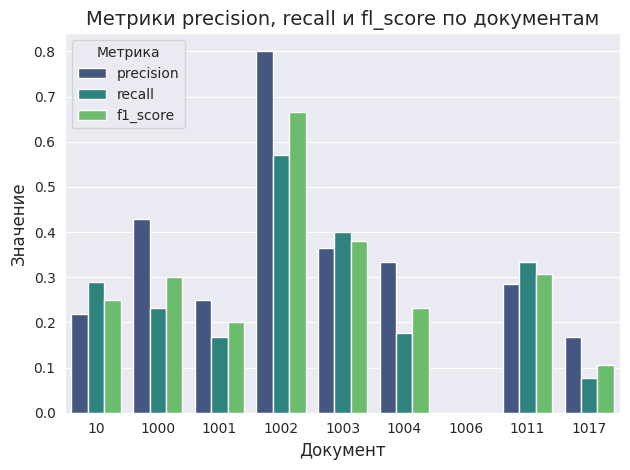

In [ ]:
results_df_long = results_df.melt(
    id_vars="document_id",
    value_vars=["precision", "recall", "f1_score"],
    var_name="metric",
    value_name="value",
)

sns.barplot(
    data=results_df_long, x="document_id", y="value", hue="metric", palette="viridis"
)
plt.title("Метрики precision, recall и fl_score по документам", fontsize=14)
plt.xlabel("Документ", fontsize=12)
plt.ylabel("Значение", fontsize=12)
plt.legend(title="Метрика", loc="upper left")

plt.tight_layout()
plt.show()

**Выводы:**

1. в датасете есть всего один пример с id документа 1002, где модель показала относительно нормальные результаты по всем метрикам. Скорее всего, это связано с тем, что в разметке и в ответах GigaChat одни и те же сущности могут быть названы по-разному: "тереза мэй" и "мэй (как глава правительства)", "борис джонсон" и "джонсон" и т.д.. Более того, иногда GigaChat генерирует слишком длинные названия сущностей, которых в целом не может быть в датасете, например: "принятие отставки бориса джонсона премьер-министром терезы мэй".

2. по результатам describe() можно сказать, что, в среднем, у модели сравнимые recall и precision, т.е. у неё нет перекоса в одну из сторон: либо выдавать слишком маленький спектр сущностей, получая высокий precision и низкий recall, либо наоборот очень большой список сущностей, получая высокий recall и низкий precision. ещё мы видим, что значения метрик обладают достаточно большой дисперсией, т.е. сильно зависят от документа.



В качестве дополнительного исследования посчитаем метрики для документов не по самим сущностям, а по их тэгам

In [ ]:
df_aggr = df.drop(["document_text"], axis=1).groupby("document_id").agg(list)
responses_df_aggr = responses_df.groupby("document_id").agg(list)

results_dict = defaultdict(list)
for i, row in responses_df_aggr.iterrows():
    tag_prec, tag_recall, tag_f1_score = score_fn(
        row["entity"], df_aggr.loc[i]["entity"]
    )
    results_dict["document_id"].append(i)
    results_dict["tag_precision"].append(tag_prec)
    results_dict["tag_recall"].append(tag_recall)
    results_dict["tag_f1_score"].append(tag_f1_score)

results_tag = pd.DataFrame.from_dict(results_dict)
results_tag

,document_id,tag_precision,tag_recall,tag_f1_score
0,10,0.750000,0.75,0.750000
1,1000,1.000000,0.60,0.750000
2,1001,0.750000,0.75,0.750000
3,1002,1.000000,0.50,0.666667
4,1003,0.666667,0.50,0.571429
5,1004,1.000000,0.75,0.857143
6,1006,1.000000,0.40,0.571429
7,1011,1.000000,0.60,0.750000
8,1017,1.000000,0.60,0.750000


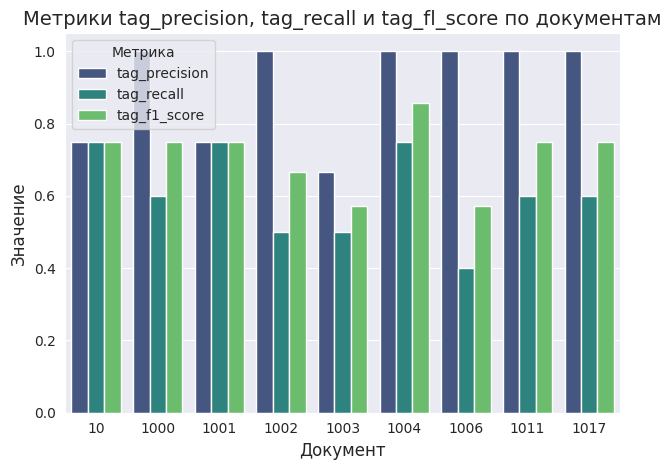

In [ ]:
results_tag = results_tag.melt(
    id_vars="document_id",
    value_vars=["tag_precision", "tag_recall", "tag_f1_score"],
    var_name="metric",
    value_name="value",
)

sns.barplot(
    data=results_tag, x="document_id", y="value", hue="metric", palette="viridis"
)
plt.title("Метрики tag_precision, tag_recall и tag_fl_score по документам", fontsize=14)
plt.xlabel("Документ", fontsize=12)
plt.ylabel("Значение", fontsize=12)
plt.legend(title="Метрика")

plt.tight_layout()
plt.show()

**Выводы:**
1. у модели достаточно высокий precision по тэгам, т.е. она в основном находит только те тэги, которые есть в разметке.

2. достаточно средний recall по тэгам, что говорит о том, что в целом она не всегда находит все тэги, котоыре есть в ground truth.

### Теперь сагрегируем результаты по каждому тэгу сущности
(я подразумеваю, что в задании имелось в виду именно это, т.к. сущности получаются достаточно уникальными, по крайней мере в ответе GigaChat, и их слишком много).

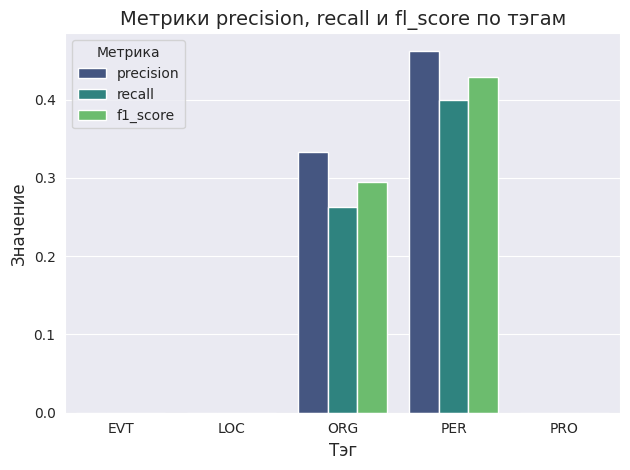

In [ ]:
df_aggr_tag = df.drop(["document_text"], axis=1).groupby("entity").agg(list)
responses_df_aggr_tag = responses_df.groupby("entity").agg(list)

results_dict = defaultdict(list)
for i, row in df_aggr_tag.iterrows():
    try:
        tag_prec, tag_recall, tag_f1_score = score_fn(
            responses_df_aggr_tag.loc[i]["pred"], row["gold_answer"]
        )
    except KeyError:
        tag_prec, tag_recall, tag_f1_score = 0, 0, 0
    results_dict["tag"].append(i)
    results_dict["precision"].append(tag_prec)
    results_dict["recall"].append(tag_recall)
    results_dict["f1_score"].append(tag_f1_score)
results = pd.DataFrame.from_dict(results_dict)
results = results.melt(id_vars="tag", var_name="metric", value_name="value")

sns.barplot(data=results, x="tag", y="value", hue="metric", palette="viridis")
plt.title("Метрики precision, recall и fl_score по тэгам", fontsize=14)
plt.xlabel("Тэг", fontsize=12)
plt.ylabel("Значение", fontsize=12)
plt.legend(title="Метрика", loc="upper left")

plt.tight_layout()
plt.show()

**Выводы:** Получилось, что сущности по тэгам находятся только для категорий ORG и PER. Я думаю, это связано с тем, что сущностей именно этих тэгов сложнее всего как-то перефразировать, поэтому GigaChat выдаёт почти те же названия, что и в ground truth. Для трёх других категорий это не совсем так, ибо, например, сущности с тэгом event GigaChat часто выделяет очень длинными, и для них ничего не находится из разметки. Более подробный анализ ошибок см. в задании 8.

## Задание 7
Есть ли зависимость метрик от длины документа? Постройте графики, чтобы ответить на вопрос.

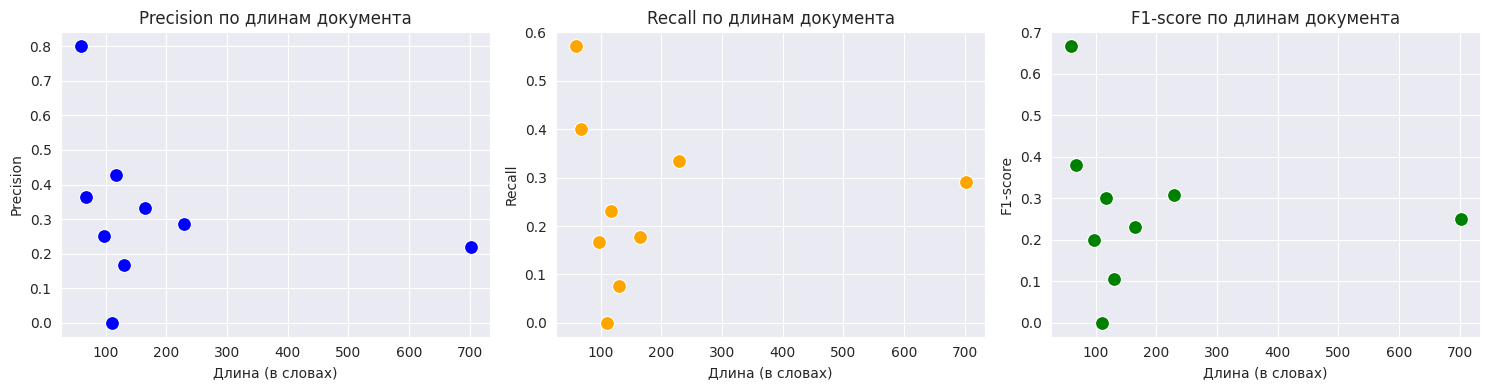

In [ ]:
results_df["doc_length"] = results_df["document_text"].apply(
    lambda x: len(x.split(" "))
)
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=results_df, x="doc_length", y="precision", color="blue", s=100)
plt.title("Precision по длинам документа")
plt.xlabel("Длина (в словах)")
plt.ylabel("Precision")

plt.subplot(1, 3, 2)
sns.scatterplot(data=results_df, x="doc_length", y="recall", color="orange", s=100)
plt.title("Recall по длинам документа")
plt.xlabel("Длина (в словах)")
plt.ylabel("Recall")

plt.subplot(1, 3, 3)
sns.scatterplot(data=results_df, x="doc_length", y="f1_score", color="green", s=100)
plt.title("F1-score по длинам документа")
plt.xlabel("Длина (в словах)")
plt.ylabel("F1-score")

plt.tight_layout()
plt.show()

Мы видим, что в целом тренды следующие (я выбрасываю из рассмотрения точку, где все три метрики 0, как аномальный документ). Для precision и f1-score наблюдается слабая отрицательная тенденция, т.е. при увеличении длины они либо немного снижаются или остаются на низком уровне. Для recall точки ещё больше разбросаны и какой-то вывод сделать достаточно сложно

Также на всех трёх метриках лучшие значения достигаются на ТОП-2 самых коротких текстов.

Получается, что явной зависимости нет, но, в целом, значения метрик чуть лучше для коротких документов, чем для длинных. Что вполне объяснимо тем, что в коротких текстах меньше сущностей, а значит, модели проще их все найти.


## Задание 8
Проведите анализ ошибок. Когда модель чаще отвечает правильно, а когда ошибается? Предложите варианты, как повысить метрики.

### Анализ по тэгам

По графикам, которые представлены выше, можно понять, что модель чаще отвечает правильно, когда нужно найти тэги ORG и PER, т.к. их сложнее всего как-то перефразировать и перепутать.



In [ ]:
responses_df[(responses_df.entity == "EVT")]

,entity,pred,document_id
21,EVT,отставка борис джонсон,10
22,EVT,прогноз эксперт,10
23,EVT,навязывание бой тереза мэй,10
24,EVT,саммит евросоюз,10
25,EVT,выход из состав евросоюз,10
26,EVT,процедура brexit,10
27,EVT,утверждение сделка с евросоюз,10
28,EVT,доклад борис джонсон,10
29,EVT,"переговоры по "" брекзиту """,10
41,EVT,заявление даунинг - стрит о благодарность джон...,1003


С тэгом EVT модель справляется уже не так хорошо, т.к. находит много false positive, т.е. приписывает этот тэг словам, которые им не являются (завершение на слове "позора", правительство терезы мэй). Более того, иногда выделяет слишком большие фразы для этого тэга, из-за чего они тоже не находятся (обсуждение детального плана выхода великобритании из ес).

In [ ]:
ENTITY_TYPES

['PER', 'ORG', 'LOC', 'EVT', 'PRO']

In [ ]:
responses_df[(responses_df.entity == "PRO")]

,entity,pred,document_id
30,PRO,экстренный закон в область регулирование финан...,10
31,PRO,"вариант "" брекзита """,10
32,PRO,торговый договор с единый европа,10
33,PRO,"компромисс , предложить мэй",10
34,PRO,таможенный союз единый европа,10
35,PRO,брекзит,10
36,PRO,предстоящий конференция партия тори,10
37,PRO,план джонсон,10
38,PRO,шантаж,10
39,PRO,соглашение с евросоюз,10


В тэг PRO модель записывает ещё больше сущностей, которые этим тэгом не является (кабинет мэй, тереза мэй, дэвид дэвис и тд)

In [ ]:
responses_df[(responses_df.entity == "LOC")]

,entity,pred,document_id


А для тэга LOC модель в целом ничего не нашла

### Анализ по длине документа

Как было отмечено выше, лучшие метрики получаются для ТОП-2 самых коротких документов, однако при дальнейшем увеличении длины этот тренд становится гораздо менее очевидным

### Варианты повышения метрик

1. поработать над промптами GigaChat: для каждого тэга дать его конкретное описание, чтобы избежать путаницы между ними.

2. добавить порог вероятности: если LLM выдает уверенность < x%, не учитывать предсказание (чтобы снизить количество False Positive)

3. лучше обрабатывать ответы GigaChat, чтобы избежать ситуаций, когда он в целом нашёл сущность, но перефразировал её так, что в ground truth не нашлось ровно такого сочетания и ответ не засчитался. Например, удалять лишние слова из его сущностей с помощью каких-нибудь паттернов. Или сопоставлять предсказанную сущность с ground truth не посимвольным сравнением, а тоже с помощью какого-то шаблона

4. возможно, отойти от использования промптинга LLM и взять специально обученные BERT-like модели или SOTA-решение GLiNER.



## Задание 9
Сделайте выводы по всему исследованию. Напишите, чему научились и что нового попробовали.



1. Глубже вникла в суть задачи NER и попыталась её решить с помощью LLM.
2. Узнала, какие в целом подходы используются для её решения.

Вся остальная работа была уже вполне себе знакомой по учебным задачам ещё с 3 курса.
